# 1. SETTINGS

In [ ]:
# This notebook was modified using Kozodoi's notebook to generate all the accuracy and fairness metrics.

In [1]:
!pip install lightgbm
!pip install imblearn
!pip install fairlearn

In [2]:
# libraries
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier

In [3]:
#metric imports
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate

In [4]:
# garbage collection
import gc
gc.enable()

In [5]:
# pandas options
pd.set_option("display.max_columns", None)

In [6]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# random settings
seed = 42

# 2. PREPARATIONS

In [8]:
# import data
train = pd.read_csv("../data/prepared/train_full_cor.csv")
test  = pd.read_csv("../data/prepared/test_full_cor.csv")
y     = pd.read_csv("../data/prepared/y_full_cor.csv")

In [9]:
# sort data
train = train.sort_values("SK_ID_CURR")
y     = y.sort_values("SK_ID_CURR")

In [10]:
# extract target
y = y["TARGET"]

In [11]:
# exclude features
excluded_feats = ["SK_ID_CURR"]
features = [f for f in train.columns if f not in excluded_feats]

In [12]:
# sensitive feature selection

sensitive_features = train['app_CODE_GENDER_M']

In [13]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 1808)
(48744, 1808)


In [14]:
### PARAMETERS

# parallel settings
cores = 10

# learner settings
metric   = "auc"
verbose  = 500
stopping = 300

# CV settings
num_folds = 5
shuffle   = True

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

In [15]:
# since the author never actually settled on a threshhold, here's a couple we can test.
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

In [16]:
# dicts to keep track of the different metric frames per fold + diff threshholds

metric_frames_all_features = {thresh: [] for thresh in thresholds}
metric_frames_top_500_features = {thresh: [] for thresh in thresholds}

In [17]:
metrics = {'accuracy': accuracy_score,'precision': precision_score,'recall': recall_score,'selection_rate': selection_rate,'false_positive_rate': false_positive_rate,'false_negative_rate': false_negative_rate}
        

# 3. CROSS-VALIDATION

## 3.1. ALL FEATURES

In [18]:
# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

# placeholders
valid_aucs_cv = np.zeros(num_folds) 
test_preds_cv = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [19]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # new!! sensitive value
    sensitive_val = sensitive_features.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits
    
    # new!! metrics
    for threshold in thresholds:
        y_pred_threshold = (valid_preds_cv > threshold).astype(int)
        # MetricFrame
        mf = MetricFrame(metrics=metrics, y_true=val_y, y_pred=y_pred_threshold, sensitive_features=sensitive_val)
        # Store the MetricFrame in the dictionary
        metric_frames_all_features[threshold].append(mf)
    
    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")
    
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % np.mean(valid_aucs_cv))

Training until validation scores don't improve for 300 rounds.
[500]	training's binary_logloss: 0.231925	training's auc: 0.812151	valid_1's binary_logloss: 0.244068	valid_1's auc: 0.768876
[1000]	training's binary_logloss: 0.217844	training's auc: 0.844312	valid_1's binary_logloss: 0.239555	valid_1's auc: 0.77994
[1500]	training's binary_logloss: 0.208677	training's auc: 0.864501	valid_1's binary_logloss: 0.238009	valid_1's auc: 0.784147
[2000]	training's binary_logloss: 0.201491	training's auc: 0.879617	valid_1's binary_logloss: 0.237298	valid_1's auc: 0.78619
[2500]	training's binary_logloss: 0.195509	training's auc: 0.891695	valid_1's binary_logloss: 0.236972	valid_1's auc: 0.787169
[3000]	training's binary_logloss: 0.190146	training's auc: 0.902152	valid_1's binary_logloss: 0.236709	valid_1's auc: 0.787979
[3500]	training's binary_logloss: 0.185016	training's auc: 0.911783	valid_1's binary_logloss: 0.236536	valid_1's auc: 0.788442
[4000]	training's binary_logloss: 0.1801	training's

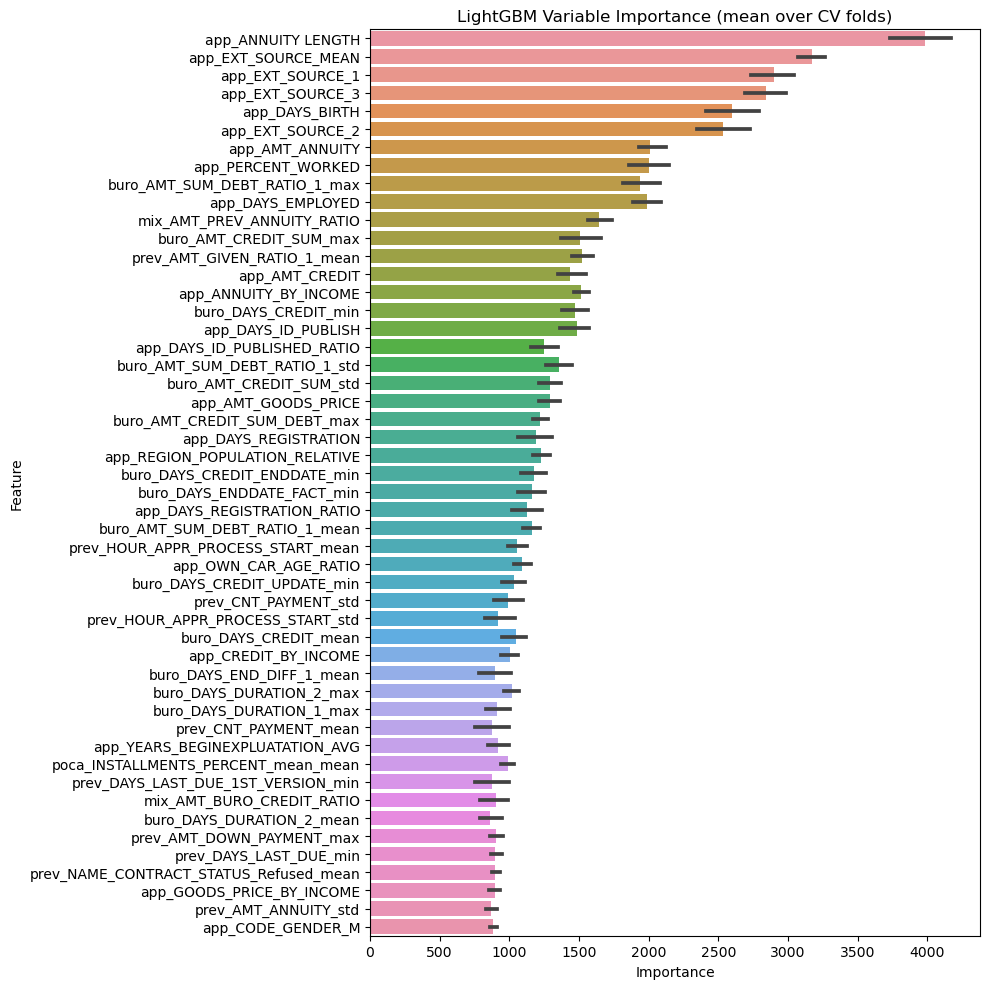

In [21]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 50
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top_feats].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "Importance", y = "Feature", data = importance.sort_values(by = "Importance", ascending = False))
plt.title('LightGBM Variable Importance (mean over CV folds)')
plt.tight_layout()

# save plot as pdf
plt.savefig("../var_importance.pdf")

## 3.2. TOP FEATURES

In [22]:
# keep top features
top = 500
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
features = list(importance.groupby("Feature").Importance.mean().sort_values(ascending = False).index)

In [23]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 500)
(48744, 500)


In [24]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # new!! sensitive value
    sensitive_val = sensitive_features.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits
    
    # new!! metrics
    for threshold in thresholds:
        y_pred_threshold = (valid_preds_cv > threshold).astype(int)
        
        # Create MetricFrame for this threshold
        mf = MetricFrame(metrics=metrics, y_true=val_y, y_pred=y_pred_threshold, sensitive_features=sensitive_val)
        
        # Store the MetricFrame in the dictionary under the corresponding threshold
        metric_frames_top_500_features[threshold].append(mf)
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % auc)

Training until validation scores don't improve for 300 rounds.
[500]	training's binary_logloss: 0.232169	training's auc: 0.811737	valid_1's binary_logloss: 0.243997	valid_1's auc: 0.768838
[1000]	training's binary_logloss: 0.218255	training's auc: 0.843523	valid_1's binary_logloss: 0.239454	valid_1's auc: 0.779993
[1500]	training's binary_logloss: 0.208995	training's auc: 0.863977	valid_1's binary_logloss: 0.23794	valid_1's auc: 0.78396
[2000]	training's binary_logloss: 0.201456	training's auc: 0.879977	valid_1's binary_logloss: 0.237246	valid_1's auc: 0.785873
[2500]	training's binary_logloss: 0.194887	training's auc: 0.893393	valid_1's binary_logloss: 0.236881	valid_1's auc: 0.786949
[3000]	training's binary_logloss: 0.18878	training's auc: 0.905477	valid_1's binary_logloss: 0.236665	valid_1's auc: 0.787618
[3500]	training's binary_logloss: 0.182932	training's auc: 0.916286	valid_1's binary_logloss: 0.23659	valid_1's auc: 0.787892
[4000]	training's binary_logloss: 0.177547	training's

In [37]:
for threshold, metric_frames in metric_frames_all_features.items():
    print(f"Results for Threshold: {threshold}")
    
    # Iterate over each MetricFrame in the list for the current threshold
    for fold_index, mf in enumerate(metric_frames):
        print(f"  Fold {fold_index + 1} Metrics:")
        
        # Print the 'overall' metrics
        print("    Overall Metrics:")
        print(mf.overall)
        print("\n")
        # Print the 'by_group' metrics
        print("    By Group Metrics:")
        print(mf.by_group)
        
        # Adding a newline for better readability between folds
        print("\n")  # Prints a newline for separation between folds
        print("-----------------------------------------------------")

Results for Threshold: 0.3
  Fold 1 Metrics:
    Overall Metrics:
accuracy               0.911956
precision              0.407025
recall                 0.198389
selection_rate         0.039348
false_positive_rate    0.025381
false_negative_rate    0.801611
dtype: float64


    By Group Metrics:
                   accuracy  precision    recall  selection_rate  \
app_CODE_GENDER_M                                                  
False              0.923468   0.387924  0.165607        0.029819   
True               0.889684   0.426094  0.241913        0.057782   

                   false_positive_rate  false_negative_rate  
app_CODE_GENDER_M                                            
False                         0.019622             0.834393  
True                          0.036919             0.758087  


-----------------------------------------------------
  Fold 2 Metrics:
    Overall Metrics:
accuracy               0.913011
precision              0.416486
recall                 

In [34]:
for threshold, metric_frames in metric_frames_top_500_features.items():
    print(f"Results for Threshold: {threshold}")
    
    # Iterate over each MetricFrame in the list for the current threshold
    for fold_index, mf in enumerate(metric_frames):
        print(f"  Fold {fold_index + 1} Metrics:")
        
        # Print the 'overall' metrics
        print("    Overall Metrics:")
        print(mf.overall)
        print("\n")
        # Print the 'by_group' metrics
        print("    By Group Metrics:")
        print(mf.by_group)
        
        # Adding a newline for better readability between folds
        print("\n")  # Prints a newline for separation between folds
        print("-----------------------------------------------------")

Results for Threshold: 0.3
  Fold 1 Metrics:
    Overall Metrics:
accuracy               0.912183
precision              0.409468
recall                 0.198590
selection_rate         0.039153
false_positive_rate    0.025151
false_negative_rate    0.801410
dtype: float64


    By Group Metrics:
                   accuracy  precision    recall  selection_rate  \
app_CODE_GENDER_M                                                  
False              0.923739   0.392562  0.167726        0.029843   
True               0.889827   0.426544  0.239569        0.057162   

                   false_positive_rate  false_negative_rate  
app_CODE_GENDER_M                                            
False                         0.019489             0.832274  
True                          0.036494             0.760431  


-----------------------------------------------------
  Fold 2 Metrics:
    Overall Metrics:
accuracy               0.912881
precision              0.414824
recall                 

# 4. SUBMISSION

In [25]:
# create submission
test["TARGET"] = test_preds_cv
subm = test[["SK_ID_CURR", "TARGET"]]

In [26]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/rmean_top10.csv")
spearmanr(test.TARGET, best.TARGET)

SignificanceResult(statistic=0.9788441827696251, pvalue=0.0)

In [27]:
# export CSV
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_bag_lgb_top" + str(top) + ".csv", index = False, float_format = "%.8f")

In [28]:
# no card, old features (560):            0.786941 | 0.783
# no card, new features (694):            0.788893 | 0.783
# with card, new features (1072):         0.790123 | 0.787
# with card and kernel features (1109):   0.790053 | 
# card, kernel, factorize, no na (978):   0.790803 | 
# card, kern, fac, nona, adummy (1193):   0.791321 |
# full data, one-hot ecoding (1844):      0.791850 |
# full data, one-hot, extra sums (2486):  0.791880 | 0.789 
# full, one-hot, sums, buroscore (2501):  0.791761 | 
# full, one-hot, clean, buroscore (1826): 0.791867 |
# last data + ext, age ratios (1828):     0.791808 |
# new app feats, remove weighted (1830):  0.794241 | 0.795
# previous data - top1000 LGB features:   0.794384 |
# select top1500 LGB features:            0.794384 |